In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from influxdb_client import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS
import yfinance as yf

# --- InfluxDB config ---
INFLUXDB_URL = "http://localhost:10896"
INFLUXDB_TOKEN = "14iJvsBJKp37nLXjIZvE4RbAoEO2dNs1k0GvCbKuJUnF_ub4pSWWw80O739jabLPMD-XBzA72WSX9f-4FuDBQ=="
INFLUXDB_ORG = "bdinf-org"
INFLUXDB_BUCKET = "bdinf-bucket"


TICKER = "NVDA"
START_DATE = "2024-01-01"
END_DATE = "2024-12-31"

In [41]:
#--- Connect to InfluxDB and query data ---
from influxdb_client import InfluxDBClient

client = InfluxDBClient(url=INFLUXDB_URL, token=INFLUXDB_TOKEN, org=INFLUXDB_ORG)
query_api = client.query_api()

# Prepare queries
query_finbert = f'''
from(bucket: "{INFLUXDB_BUCKET}")
  |> range(start: {START_DATE}T00:00:00Z, stop: {END_DATE}T23:59:59Z)
  |> filter(fn: (r) => r["_measurement"] == "sentiment_data")
  |> filter(fn: (r) => r["ticker"] == "{TICKER}")
  |> filter(fn: (r) => r["_field"] == "avg_sentiment_score")
  |> aggregateWindow(every: 1d, fn: mean)
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> yield(name: "pivoted")
'''

query_alpha = f'''
from(bucket: "{INFLUXDB_BUCKET}")
  |> range(start: {START_DATE}T00:00:00Z, stop: {END_DATE}T23:59:59Z)
  |> filter(fn: (r) => r["_measurement"] == "sentiment_alphavantage")
  |> filter(fn: (r) => r["ticker"] == "{TICKER}")
  |> filter(fn: (r) => r["_field"] == "avg_sentiment")
  |> aggregateWindow(every: 1d, fn: mean)
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> yield(name: "pivoted")
'''

# Run queries
df_finbert = query_api.query_data_frame(org=INFLUXDB_ORG, query=query_finbert)
df_alpha = query_api.query_data_frame(org=INFLUXDB_ORG, query=query_alpha)

# Clean up both DataFrames
finbert_df = df_finbert[['_time', 'avg_sentiment_score']].rename(columns={'_time': 'Date', 'avg_sentiment_score': 'FinBERT'})
alpha_df = df_alpha[['_time', 'avg_sentiment']].rename(columns={'_time': 'Date', 'avg_sentiment': 'AlphaVantage'})

# Format and merge
finbert_df['Date'] = pd.to_datetime(finbert_df['Date'])
alpha_df['Date'] = pd.to_datetime(alpha_df['Date'])

finbert_df.set_index('Date', inplace=True)
alpha_df.set_index('Date', inplace=True)

# Merge
sentiment_df = finbert_df.join(alpha_df, how='inner')
sentiment_df['Difference'] = sentiment_df['AlphaVantage'] - sentiment_df['FinBERT']


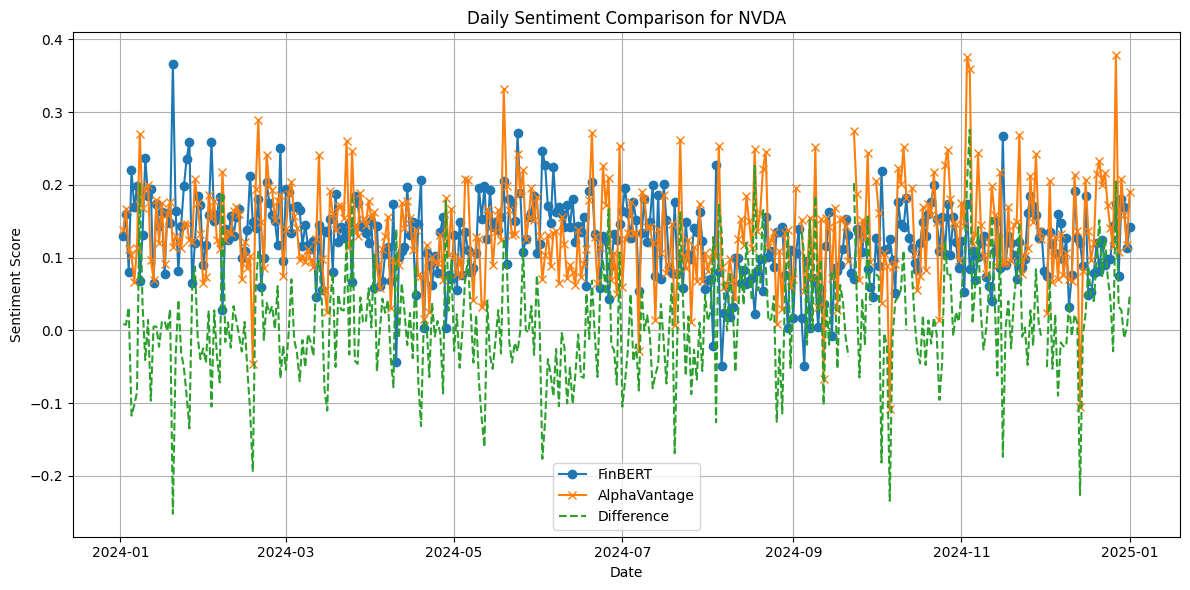

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(sentiment_df.index, sentiment_df['FinBERT'], label='FinBERT', marker='o')
plt.plot(sentiment_df.index, sentiment_df['AlphaVantage'], label='AlphaVantage', marker='x')
plt.plot(sentiment_df.index, sentiment_df['Difference'], label='Difference', linestyle='--')
plt.title(f"Daily Sentiment Comparison for {TICKER}")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Normalization

In [43]:
# --- Z-score normalization ---
def z_score_normalize(series):
    return (series - series.mean()) / series.std()

# Apply normalization
sentiment_df['FinBERT_z'] = z_score_normalize(sentiment_df['FinBERT'])
sentiment_df['AlphaVantage_z'] = z_score_normalize(sentiment_df['AlphaVantage'])
sentiment_df['Difference_z'] = sentiment_df['AlphaVantage_z'] - sentiment_df['FinBERT_z']

# Optional: preview
sentiment_df[['FinBERT_z', 'AlphaVantage_z', 'Difference_z']].head()


,FinBERT_z,AlphaVantage_z,Difference_z
Date,,,
2024-01-02 00:00:00+00:00,0.110344,0.066426,-0.043918
2024-01-03 00:00:00+00:00,0.662161,0.515419,-0.146741
2024-01-04 00:00:00+00:00,-0.779172,-0.327162,0.452010
2024-01-05 00:00:00+00:00,1.775440,-0.463732,-2.239172
2024-01-06 00:00:00+00:00,0.834097,-1.033126,-1.867223


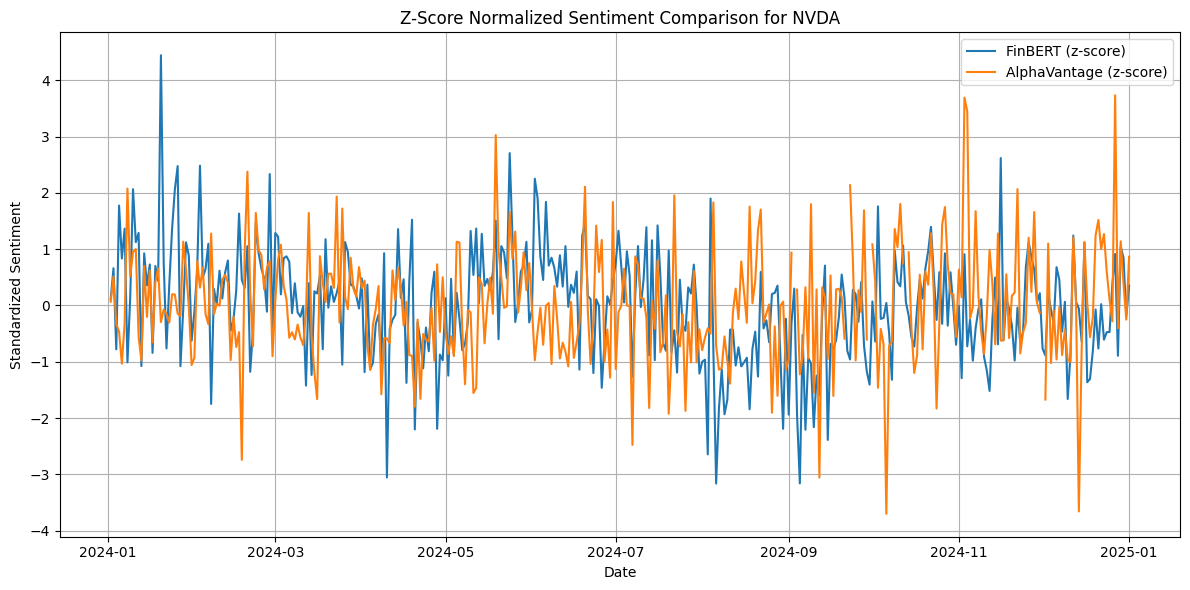

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(sentiment_df.index, sentiment_df['FinBERT_z'], label='FinBERT (z-score)')
plt.plot(sentiment_df.index, sentiment_df['AlphaVantage_z'], label='AlphaVantage (z-score)')
#plt.plot(sentiment_df.index, sentiment_df['Difference_z'], label='Difference', linestyle='--')
plt.title(f"Z-Score Normalized Sentiment Comparison for {TICKER}")
plt.xlabel("Date")
plt.ylabel("Standardized Sentiment")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Rolling Avg

In [45]:
# --- Add rolling averages (7-day window) ---
ROLLING_WINDOW = 7  # You can adjust to 5, 14, etc.

sentiment_df['FinBERT_z_roll'] = sentiment_df['FinBERT_z'].rolling(window=ROLLING_WINDOW).mean()
sentiment_df['AlphaVantage_z_roll'] = sentiment_df['AlphaVantage_z'].rolling(window=ROLLING_WINDOW).mean()
sentiment_df['Difference_z_roll'] = sentiment_df['Difference_z'].rolling(window=ROLLING_WINDOW).mean()


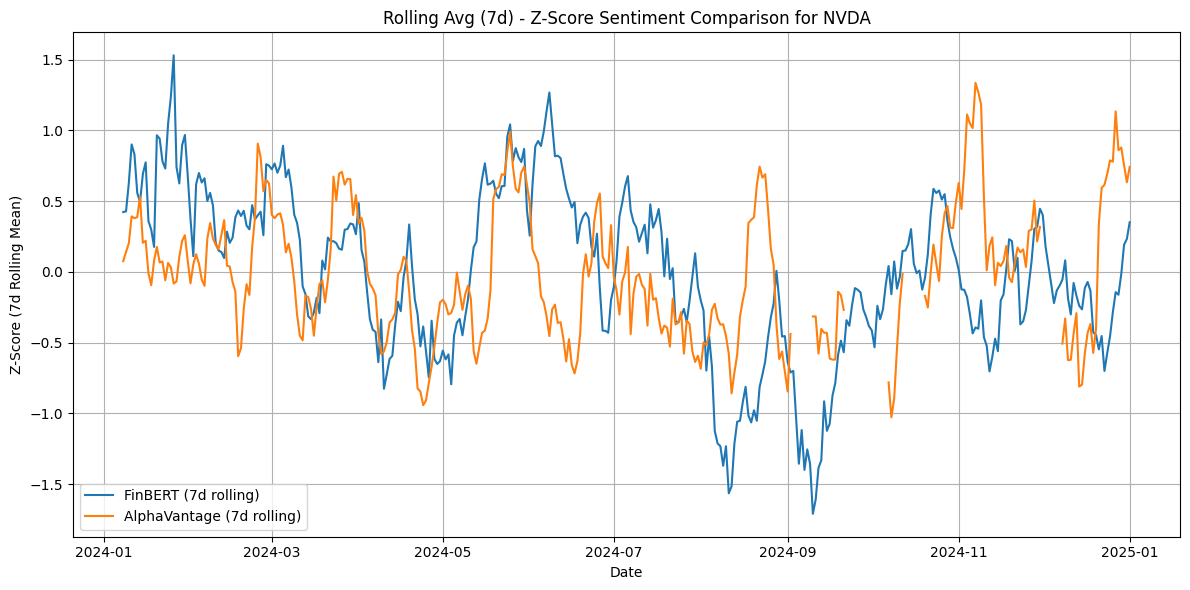

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(sentiment_df.index, sentiment_df['FinBERT_z_roll'], label='FinBERT (7d rolling)', linestyle='-')
plt.plot(sentiment_df.index, sentiment_df['AlphaVantage_z_roll'], label='AlphaVantage (7d rolling)', linestyle='-')
#plt.plot(sentiment_df.index, sentiment_df['Difference_z_roll'], label='Difference (7d rolling)', linestyle='--')
plt.title(f"Rolling Avg (7d) - Z-Score Sentiment Comparison for {TICKER}")
plt.xlabel("Date")
plt.ylabel("Z-Score (7d Rolling Mean)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
